#Plotting the number of images per class in the dataset

In [1]:
# import dependencies
import os

# setting some variables
ROOT = '/content/drive/MyDrive/desafioicts/dataset/'
IMGS_PATH = '/content/drive/MyDrive/desafioicts/dataset/images/images'

# set with names of the files that do not open correctly
bad = {'Abyssinian_34.jpg', 'Egyptian_Mau_145.jpg', 'Egyptian_Mau_139.jpg', 'Egyptian_Mau_191.jpg', 'Egyptian_Mau_177.jpg', 'Egyptian_Mau_167.jpg'}

# list with 'good' file names without the extension
all_imgs = [i for i in os.listdir(IMGS_PATH) if i.rsplit('.',1)[1] == 'jpg' and i not in bad]

# some general information
print('We have ' + str(len(all_imgs)) + ' good images.')
print('(for some reason, there are ' + str(len(bad)) + ' that do not want to open)')

We have 7384 good images.
(for some reason, there are 6 that do not want to open)


In [2]:
# getting info from 'list.txt' file
l = open(ROOT + '/annotations/annotations/list.txt', 'r')

# lambda functions to get breed and species from the annotations
get_breed = lambda pic : pic.rsplit('_',1)[0].lower()
get_species = lambda num : 'cat' if num==1 else 'dog'

# dictionaries where data will be stored
info_by_id = {}
info_by_breed = {}

# loop through every line in the 'list.txt' file
for line in l:
  
  # if it has an '#' in the begining then we are to ignore it
  if line[0] == '#':
    continue
  
  # we create a list with the info in the row
  line = line.strip().split(' ')
  
  # we get the species information, the id, the breed id and the name from the file for each row
  species = get_species(int(line[2]))
  id = int(line[1])
  breedid = int(line[3])
  name = get_breed(line[0]).lower()
  
  # then we store this information in the dictionaries
  # 2 dictionaries are used in order to make the accessing the information easier!
  if name not in info_by_breed:
    info_by_breed[name] = {'breed' : name, 'species' : species, 'globalid': id, 'breedid':breedid, 'count':0}
    info_by_id[id] = info_by_breed[name]

# now we can count the number of examples for each breed
for p in [get_breed(n) for n in all_imgs]:
  info_by_breed[p]['count']+=1

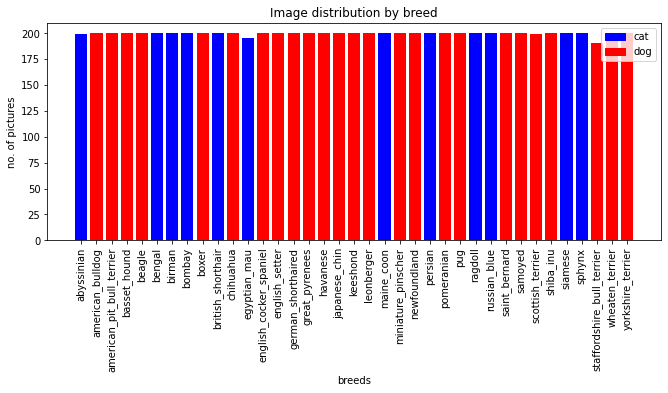

There are 2394 images of cats, and 4990 of dogs!


In [3]:
# we need to import this:
import matplotlib.pyplot as plt

# getting all the breed ids from the dictionaries
ids = list(info_by_id.keys())

# creating a list with all the Y values (number of examples per breed) ordered by id
counts = [info_by_id[id]['count'] for id in ids]

# creating a list of the names of the breeds ordered by id
x_labels = [info_by_id[i]['breed'] for i in ids]

# setting the bar colour depending on whether it is a cat or a dog
colours = [ 'blue' if info_by_id[id]['species']=='cat' else 'red' for id in ids]

# preparing labels and legend
colours_leg = {'cat': 'blue', 'dog':'red'}
labels = list(colours_leg.keys())
handles = [plt.Rectangle((0,0),1,1, color=colours_leg[label]) for label in colours_leg]

# plotting
fig, ax = plt.subplots( figsize= (11,4))
ax.bar(ids, counts, color=colours)

# set ticks and axis labels and legend:
ax.set_xticks(ids)
ax.set_xticklabels(x_labels, rotation='vertical')
plt.legend(handles, labels)
plt.xlabel('breeds')
plt.ylabel('no. of pictures')
plt.title('Image distribution by breed')
plt.show()

# determining numbers of examples of cats and dogs
nr_cats = sum([ info_by_id[id]['count'] for id in ids if info_by_id[id]['species'] == 'cat' ])
nr_dogs = sum([ info_by_id[id]['count'] for id in ids if info_by_id[id]['species'] == 'dog' ])
print('There are ' + str(nr_cats) + ' images of cats, and ' + str(nr_dogs) + ' of dogs!')

#Creating the Tensorflow model

In [4]:
# more imports
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.optimizers import Adam

def getModel(dropout=.25, learning_rate=0.001, augmentation=False):
  # 'frozen' base model
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
  base_model.trainable = False

  # input layer
  inputs = tf.keras.Input(shape=(299, 299, 3))
  x = inputs
  
  # pass results to a preprocessing layer
  x = tf.keras.applications.inception_v3.preprocess_input(x)
  
  # send results to the already trained model
  x = base_model(x, training=False)
  
  # send results to pooling layer
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  
  # send to fully connected layer
  x = tf.keras.layers.Dense(256,activation='relu')(x)
  
  # send to dropout layer
  x = tf.keras.layers.Dropout(dropout)(x)
  
  # send to batch normalization layer
  x = tf.keras.layers.BatchNormalization()(x)
   
  # send to output dense layer with SoftMax activation function
  outputs = tf.keras.layers.Dense(37,activation='softmax')(x)
  
  # create a model with these layers
  model = tf.keras.Model(inputs, outputs)
  
  # show some information
  model.summary()

  # compile model with Adam optimizer
  # and chosing accuracy as the metric to evaluate the model performance during training
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

  return model

#Preparing Images and Labels

In [5]:
# some more imports
import random
import cv2
import numpy as np

# setting image pixel side size
IMG_SIZE = 299

def getXy():
  # function that returns the number correspondent to the breed of 
  # the animal in the image, given the image name
  get_class_no = lambda name : info_by_breed[get_breed(name)]['globalid']
  
  # all image tensors will be stored here after resizing
  training_data = []
  
  for img in all_imgs:
    path = os.path.join(IMGS_PATH, img)
  
    # this is a trick to make the image be opened in RGB format, which is not the default
    img_array = cv2.imread(path)[...,::-1] 

    # here the images are rezise
    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
  
    # get the ID of the image class
    class_no = get_class_no(img)

    # relates the breed id to the corresponding image
    training_data.append([img_array, class_no])
    
  # data should be in random order to improve performance
  random.shuffle(training_data)
  
  # separating data from list
  training = list(zip(*training_data))
  X = training[0]
  y = training[1]
  
  # transforming X to an np.array and resizing
  X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
  return X, y

In [6]:
getXy()

(array([[[[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [ 27,  29,  11],
          [ 25,  28,   9],
          [ 25,  28,   9]],
 
         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [ 27,  30,  11],
          [ 27,  30,  11],
          [ 26,  29,  10]],
 
         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [ 26,  29,  10],
          [ 27,  29,  11],
          [ 25,  28,   9]],
 
         ...,
 
         [[ 62, 101,  33],
          [132, 161,  53],
          [102, 143,  20],
          ...,
          [170, 194,  88],
          [159, 181,  97],
          [186, 209,  83]],
 
         [[108, 143,  77],
          [ 89, 118,  21],
          [120, 163,  45],
          ...,
          [146, 176,  51],
          [113, 138,  37],
          [182, 207,  98]],
 
         [[132, 162,  93],
          [ 86, 129,  34],
          [128, 168,  58],
   

In [7]:
X, y = getXy() # execute with GPU (without GPU = 17min, with GPU = )

#Splitting the training and testing data

In [8]:
# one more import
from sklearn.model_selection import train_test_split

# stratified split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [9]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
def onehotencode_func(y):
    y = np.asarray(y)
    integer_encoded = y.reshape(len(y), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

#Training and Evaluating the Model

In [10]:
# get an instance of the model
model = getModel(learning_rate=0.001, dropout=0.35)

# train the model
model.fit(x_train, onehotencode_func(y_train), batch_size=32, epochs=15)

# predict for the test data
y_pred = model.predict(x_test)

# convert values in the array from one-hot encoding to decimal numbers
y_pred_id = [ np.argmax(i)+1 for i in y_pred]

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                       

In [11]:
print(y_test)
print(y_pred_id)

[36, 18, 36, 4, 34, 12, 19, 22, 24, 11, 26, 20, 35, 21, 20, 12, 19, 5, 29, 8, 1, 33, 27, 22, 12, 16, 31, 31, 1, 28, 13, 28, 33, 6, 24, 14, 34, 32, 29, 3, 2, 23, 3, 31, 2, 14, 34, 5, 1, 34, 33, 1, 36, 32, 31, 30, 2, 20, 23, 28, 32, 9, 10, 4, 17, 23, 31, 31, 29, 28, 32, 30, 26, 31, 32, 3, 35, 14, 11, 1, 37, 37, 8, 30, 10, 36, 28, 17, 31, 35, 19, 32, 17, 32, 30, 8, 23, 7, 16, 16, 25, 29, 1, 30, 30, 5, 31, 16, 4, 16, 16, 24, 29, 13, 23, 4, 11, 35, 7, 1, 23, 4, 26, 23, 10, 16, 8, 14, 35, 2, 11, 12, 5, 2, 6, 19, 12, 21, 20, 22, 29, 32, 25, 19, 24, 1, 32, 18, 13, 17, 28, 21, 30, 8, 10, 35, 7, 35, 30, 34, 30, 24, 21, 32, 18, 4, 35, 23, 36, 5, 4, 13, 17, 2, 19, 32, 35, 16, 27, 25, 32, 31, 2, 19, 9, 8, 20, 28, 12, 8, 27, 7, 36, 34, 3, 34, 6, 29, 9, 10, 24, 20, 11, 19, 6, 33, 33, 27, 30, 9, 25, 4, 28, 10, 31, 34, 32, 15, 3, 12, 35, 11, 4, 22, 26, 15, 24, 35, 35, 30, 30, 36, 18, 33, 19, 37, 25, 13, 6, 30, 27, 24, 25, 23, 25, 4, 2, 16, 17, 16, 31, 13, 27, 25, 12, 4, 25, 25, 18, 33, 28, 3, 21, 22, 1

In [12]:
import tensorflow as tf
from keras.preprocessing import image

In [13]:
single_img_path = image.load_img('/content/drive/MyDrive/desafioicts/single_images_test/cat1-siamese.jpg', target_size=(299,299))
single_img = tf.keras.preprocessing.image.img_to_array(single_img_path)
single_img = np.expand_dims(single_img, axis=0)

single_img_pred = model.predict(single_img)
print(f"Previsão da imagem submetida: {info_by_id[np.argmax(single_img_pred) + 1]['breed']}")

Previsão da imagem submetida: siamese


In [14]:
np.argmax(single_img_pred)

32

In [15]:
len(single_img_pred[0])

37

#Confunsion Matrix

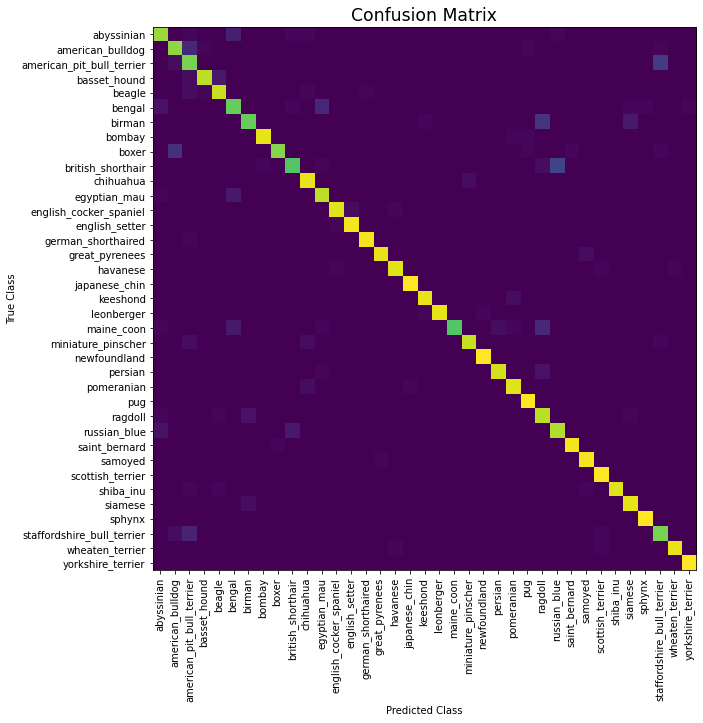

In [16]:
from sklearn import metrics

# this will compute the matrix
cm = metrics.confusion_matrix(y_test, y_pred_id)

# preparing for the plot
fig, ax = plt.subplots( figsize= (10, 10))

# displays data as an image
ax.imshow(cm)

# setup for labels, etc
ax.set_xticks(range(0, 37))
ax.set_yticks(range(0, 37))

ax.set_yticklabels(x_labels)
ax.set_xticklabels(x_labels, rotation='vertical')

plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix', size='xx-large')
plt.show()

#Inferences based on confusion matrix analysis

###Cat Breeds That Are Very Similar: \
Ragdoll - Birman, \
Bengal - Egyptian Mau, \
British Shorthair - Russian Blue.

###Dog Breeds That Are Very Similar: \
American Pit Bull Terrier - Staffordshire Bull Terrier, \
American bulldog - Boxer.

#Fine Tuning Base Model

In [17]:
# first we need to find the base model layer in our model
for l in model.layers:
    if l.name == 'inception_v3':
        base_model = l
        break

# then we unfreeze all of it
base_model.trainable = True

# fine-tune layers from 2/3 of the base model (that should be about 207)
fine_tune_at = 207

# freeze all the layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

#Compile the Model to Fine Tuning

In [19]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

#Fine Tuning

In [20]:
# train the model
model.fit(x_train, onehotencode_func(y_train), batch_size=32, epochs=10)

Epoch 1/10
162/162 [==============================] - 79s 433ms/step - loss: 0.2762 - accuracy: 0.9143
Epoch 2/10
162/162 [==============================] - 69s 426ms/step - loss: 0.1381 - accuracy: 0.9534
Epoch 3/10
162/162 [==============================] - 69s 425ms/step - loss: 0.0994 - accuracy: 0.9708
Epoch 4/10
162/162 [==============================] - 69s 426ms/step - loss: 0.0944 - accuracy: 0.9727
Epoch 5/10
162/162 [==============================] - 69s 425ms/step - loss: 0.0444 - accuracy: 0.9868
Epoch 6/10
162/162 [==============================] - 69s 425ms/step - loss: 0.0507 - accuracy: 0.9837
Epoch 7/10
162/162 [==============================] - 69s 425ms/step - loss: 0.0300 - accuracy: 0.9925
Epoch 8/10
162/162 [==============================] - 69s 426ms/step - loss: 0.0303 - accuracy: 0.9911
Epoch 9/10
162/162 [==============================] - 69s 424ms/step - loss: 0.0151 - accuracy: 0.9969
Epoch 10/10
162/162 [==============================] - 69s 424ms/step - l

#Saving the Model

In [ ]:
model.save('catsdogs_breeds.h5')